In [1]:
!pip install matplotlib --quiet
!pip install livelossplot --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi


In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =4 
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 512

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("tordjx/model_en"))
# model_fr.load_state_dict(torch.load("tordjx/model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)

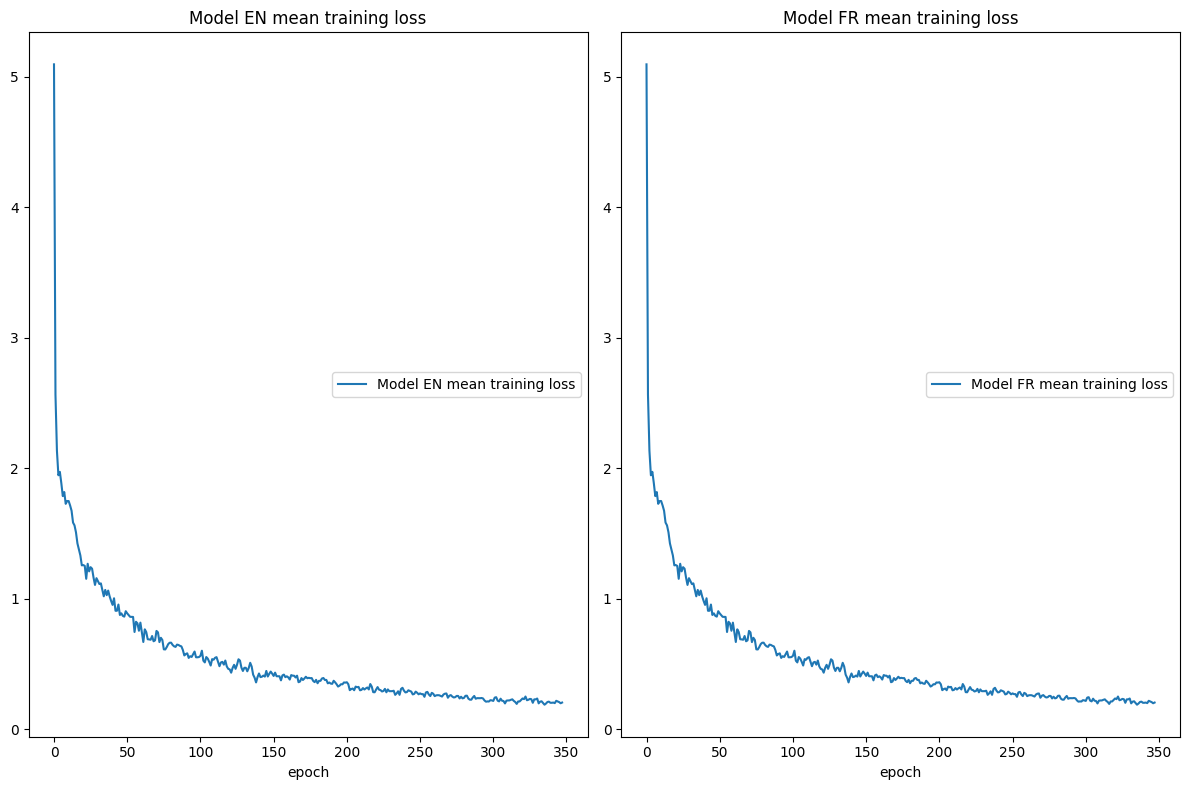

Model EN mean training loss
	Model EN mean training loss 	 (min:    0.188, max:    5.094, cur:    0.205)
Model FR mean training loss
	Model FR mean training loss 	 (min:    0.188, max:    5.094, cur:    0.205)


KeyboardInterrupt: 

In [4]:
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
mixed_train(model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,[1/2,1])


23.764413793103447


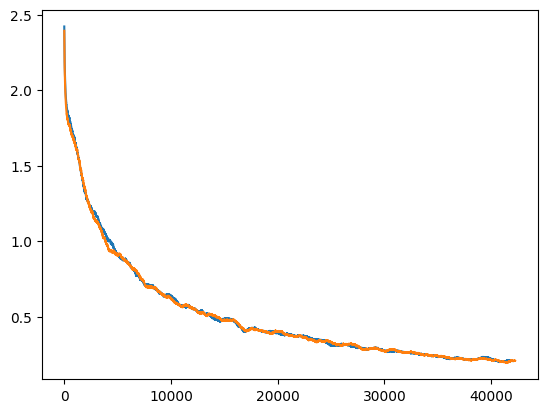

In [6]:
def moving_average(a, n=1000,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
# plt.plot(model_en.loss_list)
print(len(model_fr.loss_list)/(29000/batch_size))


In [7]:
torch.save(model_fr.state_dict(), "tordjx/model_fr")
torch.save(model_en.state_dict(), "tordjx/model_en")
import os
import s3fs
!pip install pandas
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("tordjx/model_fr","tordjx/model_fr")
fs.upload("tordjx/model_en","tordjx/model_en")

In [8]:

train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]

def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" or word == "TOKEN_VIDE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map,image_bool):
    model_en.eval()
    model_fr.eval()
    if image_bool : 
        data,features= data

    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data,features, True),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)



def donne_random():
    i = np.random.randint(len(tokenized_en)//batch_size)
    j = np.random.randint(batch_size)
    batched_data=batchify(train_data_en,batch_size,True)
    data,features = batched_data
    return data[i],features[i]

text,features = donne_random()
features = features.to(device,dtype=torch.float32)
data = [text,features]
for i in range(10):
    j = np.random.randint(batch_size)
    print("Phrase à traduire : \n" + tensor_to_sentence(text[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr,True))


#%%

/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Phrase à traduire : 
a group of indians stand next to a streetlight in the daytime with clouds above them all . 
 Phrase traduite : 
 un groupe ta reau vscène grand mun sur et rablanc ocsur pdans l une le irde bois grand trottoir i. 
Phrase à traduire : 
a man wearing snowshoes is going down a hill next to tiny orange flags . 
 Phrase traduite : 
 un homme et trorant ement m. autre un maillot grand mai e acrobatiboî. 
Phrase à traduire : 
a boy jumps into a pool while lifeguards watch . 
 Phrase traduite : 
 un personne court x un noire devant t , ren de du bois tée . 
Phrase à traduire : 
a man with a tattoo on his arm plays the accordion . 
 Phrase traduite : 
 un homme une un adebout ts cheval d&apos; te tant vicple le rbred&apos; . 
Phrase à traduire : 
a little girl is sitting in a metal tub filled with water . 
 Phrase traduite : 
 un femme enfant msur oun és ade age arrière-plan une son . 
Phrase à traduire : 
a man is approaching a parachute that he might just have used to land